In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [11]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
from kaggle_environments import make, evaluate


env = make("connectx", debug=True)

print(list(env.agents))

env.run(["random", "random"])

env.render(mode="ipython")

['random', 'negamax']


In [5]:
import random

# toycase agent
def agent_random(obs, config):
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    return random.choice(valid_moves)

def agent_middle(obs, config):
    return config.columns//2

def agent_leftmost(obs, config):
    valid_moves = [col for col in range(config.columns) if obs.board[col] == 0]
    return valid_moves[0]

# run an episode with agent leftmost & agent_random
env.run([agent_leftmost, agent_random])

# Show the game
env.render(mode="ipython")

In [6]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make
import random
import tensorflow as tf
import time
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [7]:
# this is my code
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=False)
        self.pair = [None, 'random']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def step(self, action):
        return self.trainer.step(action)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def reset(self):
        if np.random.random() < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()

class DQNAgent:
    def __init__(self, state_size, action_size, gamma, batch_size, model_path=None):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = gamma    # discount rate
        self.epsilon = 1  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99998
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.state_size, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='BCE'))
        model.compile(loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        state = self.preprocess(state)
        next_state = self.preprocess(next_state)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Choose a random valid action
            valid_actions = [i for i in range(self.action_size) if state[i] == 0]
            a = random.choice(valid_actions) if valid_actions else random.randrange(self.action_size)
            return int(a)
        else:
            # Get predictions for all actions
            board_data = np.array(state).reshape(1, -1)
            
            # Ensure the model is on the GPU
            with tf.device('/GPU:0'):
                predictions = self.model.predict(board_data)[0]

            # Set invalid actions to a very low value
            for i in range(self.action_size):
                if state[i] != 0:
                    predictions[i] = -1e7

            # Choose the action with the highest Q-value among valid actions
            valid_actions = [i for i in range(self.action_size) if state[i] == 0]
            a = np.argmax(predictions) if valid_actions else random.randrange(self.action_size)
            return int(a)



    def train(self):
        if len(self.memory) < 65:
            return 0

        # Sample a minibatch from the memory
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([state for state, _, _, _, _ in minibatch])
        actions = np.array([action for _, action, _, _, _ in minibatch])
        rewards = np.array([reward for _, _, reward, _, _ in minibatch])
        next_states = np.array([next_state for _, _, _, next_state, _ in minibatch])
        dones = np.array([done for _, _, _, _, done in minibatch])

        # Compute the targets
        targets = rewards + self.gamma * np.max(self.model.predict(next_states), axis=1) * (1 - dones)
        target_f = self.model.predict(states)
        target_f[np.arange(len(actions)), actions] = targets

        # Perform one optimization step on the GPU
        with tf.device('/gpu:0'):
            with tf.GradientTape() as tape:
                predictions = self.model(states, training=True)
                loss = tf.reduce_mean(tf.square(target_f - predictions))

            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))


    def load_model_weights(self, model_path):
        self.model.load_weights(model_path)

    def preprocess(self, state):
        result = state.board[:]
        return result


In [8]:
def play_game(env, TrainNetwork):
    rewards = 0
    done = False
    observations = env.reset()
    while not done:
        # Using epsilon-greedy to get an action
        action = TrainNetwork.act(observations.board)

        # Caching the information of current state
        prev_observations = observations

        # Take action
        observations, reward, done, _ = env.step(action)

        # Apply new rules
        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: # Draw
                reward = 10
        else:
            reward = -0.05 # Try to prevent the agent from taking a long move

        rewards += reward

        observations = observations

        # Adding experience into buffer
        TrainNetwork.remember(prev_observations, action, reward, observations, done)

        # Train the training model by using experiences in buffer and the target model
        TrainNetwork.train()

    return rewards

In [20]:
# Define environment
env = ConnectX()

# Initialize agent
state_size = 42  # Example size for Connect Four environment
action_size = 7  # Example size for Connect Four environment
gamma = 0.9
batch_size = 32
lr = 0.01
TrainNetwork = DQNAgent(state_size, action_size, gamma, batch_size)
path = 'weights1_2.h5'
TrainNetwork.load_model_weights(path)

# Set parameters
episodes = 1000

all_total_rewards = np.empty(episodes)
all_avg_rewards = np.empty(episodes)
all_epsilons = np.empty(episodes)

In [10]:
for n in range(episodes):
    TrainNetwork.epsilon = max(TrainNetwork.epsilon_min, TrainNetwork.epsilon * TrainNetwork.epsilon_decay)
    total_reward = play_game(env, TrainNetwork)
    all_total_rewards[n] = total_reward
    avg_reward = all_total_rewards[max(0, n - 100):(n + 1)].mean()
    all_avg_rewards[n] = avg_reward
    all_epsilons[n] = TrainNetwork.epsilon


#     with summary_writer.as_default():
#         tf.summary.scalar('episode reward', total_reward, step=n)
#         tf.summary.scalar('running avg reward (100)', avg_reward, step=n)
#         tf.summary.scalar('epsilon', epsilon, step=n)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

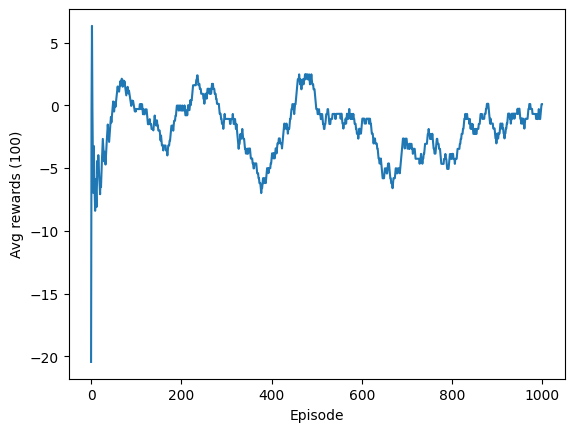

In [14]:
import matplotlib.pyplot as plt
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()

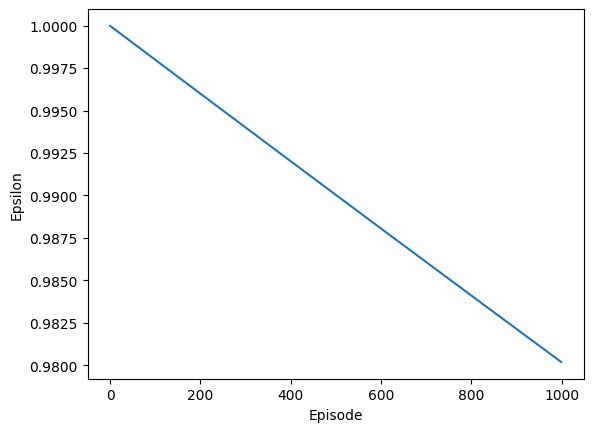

In [16]:
import matplotlib.pyplot as plt
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [ ]:
# Save weights of the model
TrainNetwork.model.save_weights('./weights1_2_local.h5')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
def mean_reward(rewards):
    valid_rewards = [r for r in rewards if r is not None]  # Filter out None values
    print("Valid rewards:", valid_rewards)
    total_valid_rewards = sum(r[0] if r is not None else 0 for r in valid_rewards)
    print("Total valid rewards:", total_valid_rewards)
    total_valid_games = sum((r[0] + r[1]) if r is not None and r[1] is not None else 0 for r in valid_rewards)
    print("Total valid games:", total_valid_games)
    if total_valid_games == 0:
        return 0  # Return 0 if there are no valid games
    return total_valid_rewards / total_valid_games




# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", ["random", "random"], num_episodes=5)))

Valid rewards: [[0, 1], [1, 0], [0, 1], [1, 0], [1, 0]]
Total valid rewards: 3
Total valid games: 5
My Agent vs Random Agent: 0.6


In [18]:
def my_agent(observation, configuration):
    board = observation.board
    act = TrainNetwork.act(observation.board)
    return act  # For example, drop the checker in the middle column


In [19]:
def mean_reward(rewards):
    print(rewards)
    return sum(r[0] for r in rewards) / sum(r[0] + r[1] for r in rewards)

# Evaluate the agent against a random agent for 10 episodes
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=500)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━